In [14]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

data_path = "../data/histograms/"

In [15]:
#variables
VAL_PCT = 0.2
N_EVENTS = 10000
EPOCHS = 100
CUDA = torch.device('cuda') 
MODEL_NAME = "jet_nr-" + str(int(time.time()))
print(MODEL_NAME)
MAX_JETS = 4

jet_nr-1643709146


In [16]:
def load_pickle_file(path, file_name):
    return pickle.load(open(path + file_name, 'rb') )

class Net(nn.Module):
    def __init__(self): #initialises class Net
        super().__init__() #initialises inherited class nn.Module
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))
# commenting out fc layers, replace value with our output
        #self.fc1 = nn.Linear(value, 512)
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, MAX_JETS+1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim=1) # flattening out
        #print(x.shape) # printing the shape of the flattened output, replace "value" above with this value
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


class CalorimeterDataset(Dataset):
    def __init__(self, images, labels):
            self.img_labels = labels
            self.images = images
            
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        return image, label


In [17]:
def label_maker(labels, max_value):
    label_lists = torch.zeros([len(labels), max_value + 1])
    labels[labels > max_value] = max_value
    for i in range (0, len(labels)):
        label = labels[i]
        label_lists[i, label] = 1 
    return label_lists


def load_data(input_file, label_file):
    val_size = int(N_EVENTS*VAL_PCT)
    train_size = int(N_EVENTS*(1-VAL_PCT))
    
    Cal_train = torch.tensor(load_pickle_file(data_path, input_file)[:-val_size]).unsqueeze(3).float().cuda()
    labels_train = torch.tensor(load_pickle_file(data_path, label_file)[:-val_size]).cuda()
    labels_train = label_maker(labels_train, MAX_JETS)

    Cal_test = torch.tensor(load_pickle_file(data_path, input_file)[-val_size:]).unsqueeze(3).float().cuda()
    labels_test = torch.tensor(load_pickle_file(data_path, label_file)[-val_size:]).cuda()
    labels_test = label_maker(labels_test, MAX_JETS)
    
    train_dataset = CalorimeterDataset(Cal_train, labels_train)
    test_dataset = CalorimeterDataset(Cal_test, labels_test)
    
    return train_dataset, test_dataset


In [18]:
#load data
traindata, testdata = load_data('jets_part1_10000events_80x80_min1jet.pkl', 'jets_part1_10000events_80x80_min1jet_labels_njets.pkl')

In [19]:

def fwd_pass(net, X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X.view(-1, 1, 80, 80).cuda())
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = F.cross_entropy(outputs, y.cuda()) # loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(net, data, size = 32):
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_acc, val_loss = fwd_pass(net, X, y)
    return val_acc, val_loss
    
def predict(net, data):
    dataset = DataLoader(data, 1, shuffle=True) #shuffle data and choose batch size
    prediction = torch.zeros(len(dataset))
    truth = torch.zeros(len(dataset))
    i = 0
    for data in tqdm(dataset):
        X, y = data
        output = net(X.view(-1, 1, 80, 80).cuda())
        prediction[i] = torch.argmax(output)
        truth[i] = torch.argmax(y)
        i = i +1
    return truth, prediction
        

def train(net, traindata, testdata, size, epochs):
    dataset = DataLoader(traindata, size, shuffle=True)
    df_labels = ["Loss", "Accuracy", "Validation loss", "Validation accuracy", "Epoch", "Iteration"]
    df_data = [[0], [0], [0], [0], [0], [0]]
    df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    for epoch in tqdm(range(epochs)):
        for data in dataset:
            i = i+1
            X, y = data
            acc, loss = fwd_pass(net, X, y, train=True)
            if i % 10 == 0:
                val_acc, val_loss = test(net, testdata, size=size)
                df_data = [float(loss), acc, float(val_loss), val_acc, epoch, i]
                #print(df_labels, df_data)
                new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                df = pd.concat([df, new_df], ignore_index=True)
    return df

In [35]:
#create NN
net = Net()
net.to(device = CUDA)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [36]:
training_results = train(net, traindata, testdata, 100, 100)

100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


<AxesSubplot:xlabel='Iteration'>

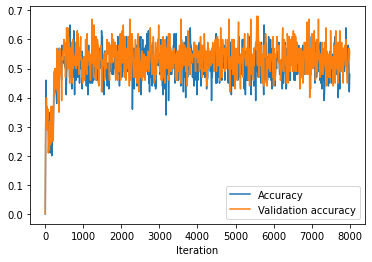

In [37]:
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"])

<AxesSubplot:xlabel='Iteration'>

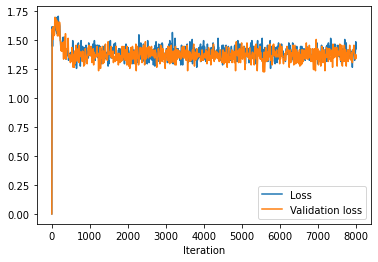

In [38]:
training_results.plot("Iteration", ["Loss", "Validation loss"])

In [39]:
truth, preds = predict(net, testdata)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
print(preds[:50])
print(truth[:50])

100%|██████████| 2000/2000 [00:01<00:00, 1318.13it/s]

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
tensor([2., 3., 2., 3., 4., 3., 2., 3., 2., 0., 0., 2., 2., 2., 2., 2., 0., 2.,
        2., 0., 2., 2., 2., 2., 2., 2., 0., 2., 4., 3., 2., 2., 0., 2., 4., 2.,
        0., 0., 2., 2., 3., 3., 2., 2., 4., 2., 3., 4., 0., 3.])


# Our network became lazy and only guesses 2 every time!!!


(0.0, 4.0)

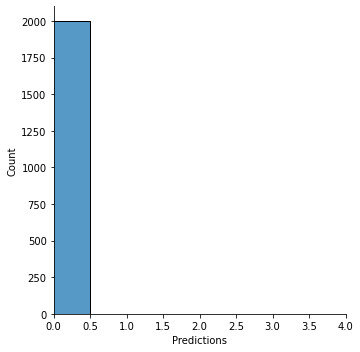

In [33]:
import seaborn as sn
sn.displot(confusion, x="Predictions", )
plt.xlim(0, 4)

(0.0, 4.0)

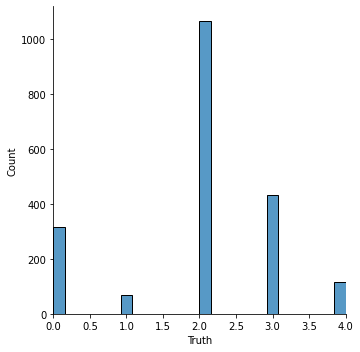

In [34]:
sn.displot(confusion, x="Truth")
plt.xlim(0, 4)